In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from math import floor


import json
from pprint import pprint

In [2]:
def save_fig(fig, name):
    fig.savefig("graphs/{}.png".format(name), format="png", dpi=500)
    fig.savefig("graphs/{}.pdf".format(name), format="pdf", dpi=500)

In [3]:
json_path="./data_balancers_border.json"
with open(json_path) as f:
    data = json.load(f)

In [4]:
prediction = []
naive = []

for d in data["datapoints"]:
    s = d["setting"]
    comp_time = list(map(lambda x: x["computationTime"],
                   d["data"]["workers"]))
    if s["balancer"] == "predictionRecursive":
        prediction += comp_time
    elif s["balancer"] == "naiveRecursive":
        naive += comp_time
     

# time in s
prediction = np.asarray(prediction) / 1e6
naive = np.asarray(naive) / 1e6
print(prediction, naive)

[0.164926 0.164783 0.271685 0.273871 0.27379  0.271727 0.278444 0.271509
 0.274193 0.272902 0.329127 0.273853 0.27325  0.274109 0.328675 0.273766
 0.328609 0.164709 0.164919 0.273821 0.273264 0.278272 0.273775 0.273922
 0.271562 0.32907  0.328661 0.328627 0.273735 0.271552 0.271548 0.273771
 0.272855 0.273989 0.273793 0.27399  0.272888 0.271611 0.27326  0.278204
 0.271552 0.27157  0.165145 0.164952 0.274063 0.273603 0.273875 0.273836
 0.328484 0.328631 0.329018 0.164935 0.164772 0.273979 0.273768 0.271571
 0.271512 0.328628 0.329055 0.27188  0.273983 0.273858 0.27289  0.273189
 0.271537 0.273528 0.328615 0.273807 0.164746 0.164893 0.271982 0.273769
 0.273803 0.273174 0.271627 0.274008 0.32868  0.328494 0.329046 0.271659
 0.273803 0.271495 0.273847 0.272819 0.274078 0.27159  0.273078 0.271937
 0.271623 0.273838 0.273989 0.273781 0.27279  0.27802  0.164913 0.280482
 0.273798 0.165036 0.273775 0.328413 0.328498 0.329116 0.164908 0.164819
 0.273914 0.273741 0.271486 0.328516 0.277988 0.272

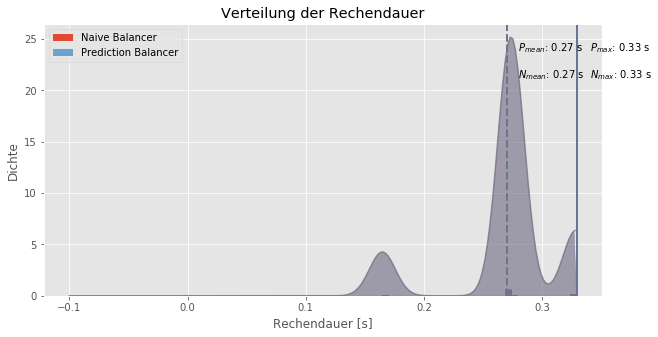

In [5]:
# Data for plotting
def histogram(y_data1, y1_label, y_data2, y2_label, 
              x_label, y_label, title):
    num_bins = 30
    plt.style.use('ggplot')
    fig, ax = plt.subplots(figsize=(10, 5))
    
    weights1 = np.ones_like(y_data1)/float(len(y_data1))
    weights2 = np.ones_like(y_data2)/float(len(y_data2))
    interval = (min(y_data1.min(), y_data2.min()),max(y_data1.max(), y_data2.max()))

    # draw histogram
    _, _, y1_patches = ax.hist(y_data1, num_bins, range=interval, weights=weights1, #density=1,  
            label=y1_label, alpha=1)
    _, _, y2_patches = ax.hist(y_data2, num_bins, range=interval, weights=weights2, #density=1,  
            label=y2_label, alpha=0.7)

    y1_color = y1_patches[0].get_facecolor()
    y2_color = y2_patches[0].get_facecolor()

    ax.legend()
    ax.set(xlabel=x_label, ylabel=y_label, title=title)
    ax.grid(True)

    def drawKDE(ax, data, color):
        # plot kernel density estimate
        density = gaussian_kde(data)
        xs = np.linspace(-0.1, data.max(), 200)
        density.covariance_factor = lambda : .25
        density._compute_covariance()
        ys = density(xs)

        alpha=0.4
        kde_line = ax.plot(xs, ys, alpha=alpha)
        kde_line[0].set_color(color)
        # TODO: Find a better way to do this
        ys[0] = 0
        ys[-1] = 0
        
        kde_fill = ax.fill(xs, ys, alpha=alpha)
        kde_fill[0].set_color(color)

    # drawKDE(ax, y_data1, y1_color)
    # drawKDE(ax, y_data2, y2_color)
    #  median
    y1_mean = y_data1.mean()
    y1_max = y_data1.max()
    y2_mean = y_data2.mean()
    y2_max = y_data2.max()
    
    def drawLine(ax, x, label, y_offset, color, style):
        ax.axvline(x, linestyle=style, lw=2, color=color)
        _, max_ = plt.ylim()
        plt.text(x + x / num_bins, 
             max_ - max_* y_offset/ 10, 
             label + ': {:.2f} s'.format(x))
        
    drawLine(ax, y1_mean, "$N_{mean}$",
             2,
             y1_color, 'dashed')
    drawLine(ax, y1_max, "$N_{max}$",
             2,
             y1_color, 'solid')
    drawLine(ax, y2_mean, "$P_{mean}$", 
             1,
             y2_color, 'dashed')
    drawLine(ax, y2_max, "$P_{max}$", 
             1,
             y2_color, 'solid')
           

    # fig.savefig("distribution.svg", format="svg")
    plt.show()
    
histogram(naive,
          "Naive Balancer",
          prediction,
          "Prediction Balancer",
          x_label='Rechendauer [s]',
          y_label='Dichte',
          title='Verteilung der Rechendauer')


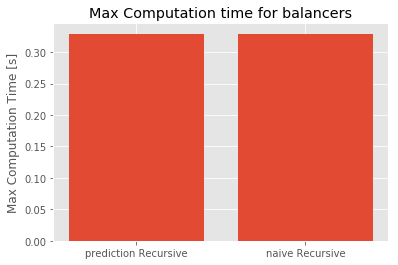

In [6]:
names= ["prediction Recursive", "naive Recursive"]
y = np.asarray([prediction.max(), naive.max()])
x = np.arange(len(y))

fig, ax = plt.subplots()
ax.bar(x, y)
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set(ylabel='Max Computation Time [s]',
      title='Max Computation time for balancers')
ax.grid(True)
plt.show()